# Optimizing Car Price Predictions

This project develops a machine learning solution for Rusty Bargain, a used car sales service, to predict vehicle market values for their customer-facing mobile application. Using a dataset of historical car sales data, I implemented and compared multiple predictive models including Linear Regression, Random Forest, and LightGBM to determine the best performance across three business metrics: prediction accuracy (measured by RMSE), prediction speed, and training efficiency. The analysis involved systematic hyperparameter tuning, proper train-validation-test data splitting, and comprehensive model evaluation to identify the best-performing algorithm that balances prediction quality with computational requirements for real-time customer use.

## Initialization and Preparation

In [1]:
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model
import sklearn.metrics
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [2]:
cars = pd.read_csv('/datasets/car_data.csv'); cars.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [3]:
cars.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [4]:
cars = cars.drop(['DateCreated', 'DateCrawled', 'LastSeen'], axis=1)
cars['VehicleType'] = cars['VehicleType'].fillna('other')
cars['Gearbox'] = cars['Gearbox'].fillna('manual')
cars['NotRepaired'] = cars['NotRepaired'].fillna('no')
cars['FuelType'] = cars['NotRepaired'].fillna('other')
cars['Model'] = cars['NotRepaired'].fillna('other')
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        354369 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            354369 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              354369 non-null  object
 6   Mileage            354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           354369 non-null  object
 9   Brand              354369 non-null  object
 10  NotRepaired        354369 non-null  object
 11  NumberOfPictures   354369 non-null  int64 
 12  PostalCode         354369 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 35.1+ MB


## Model training

In [5]:
cars = pd.get_dummies(cars, drop_first=True)
features = cars.drop(['Price'], axis=1)
target = cars['Price']

features_temp, features_train, target_temp, target_train = train_test_split(
    features, target, test_size=0.4, random_state=54321)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=54321)

In [29]:
def speed(model):
    start_time = time.time()
    model.fit(features_train, target_train)
    training_time = time.time() - start_time
    
    start_time = time.time()
    predictions = model.predict(features_train)
    prediction_time = time.time() - start_time
    print(f'Training Time: {training_time:.2f}s\nPrediction Time: {prediction_time:.2f}s')

In [30]:
def rmse(model):
    pred_train = model.predict(features_train)
    pred_valid = model.predict(features_valid)
    pred_test = model.predict(features_test)
    
    print("Train RMSE:", round(math.sqrt(mean_squared_error(target_train, pred_train)), 2))
    print("Valid RMSE:", round(math.sqrt(mean_squared_error(target_valid, pred_valid)), 2))
    print("Test RMSE:", round(math.sqrt(mean_squared_error(target_test, pred_test)), 2))

In [40]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
print(f'Linear Regression Model\n', '-'*23)
rmse(model)
speed(model)

Linear Regression Model
 -----------------------
Train RMSE: 3530.59
Valid RMSE: 3550.51
Test RMSE: 3537.42
Training Time: 0.41s
Prediction Time: 0.11s


In [53]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(10, 100, 10):
    for depth in range (1, 11):
        model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=54321)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = math.sqrt(mean_squared_error(target_valid, predictions))
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

model = RandomForestRegressor(random_state=54321, max_depth=best_depth, n_estimators=best_est)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
print(f'Random Forest RMSE\n', '-'*22)
rmse(model)
speed(model)

Random Forest RMSE
 ----------------------
Train RMSE: 1940.54
Valid RMSE: 2067.01
Test RMSE: 2051.16
Training Time: 26.12s
Prediction Time: 0.72s


In [41]:
model = LGBMRegressor(n_estimators=150, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
print(f'LightGBM Model\n', '-'*18)
rmse(model)
speed(model)

LightGBM Model
 ------------------
Train RMSE: 1811.29
Valid RMSE: 1885.18
Test RMSE: 1870.38
Training Time: 1.79s
Prediction Time: 0.69s


## Model Analysis

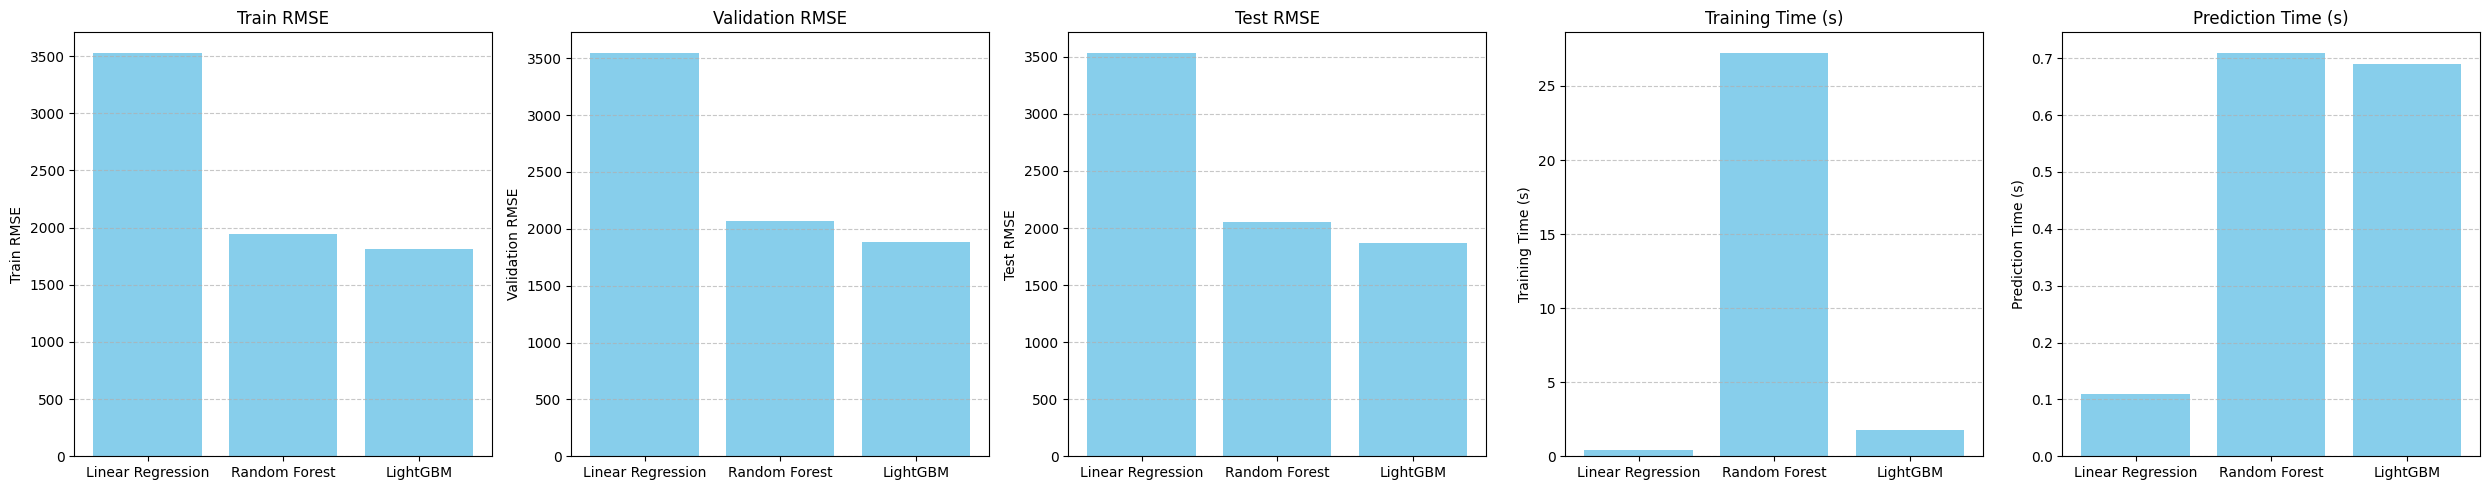

In [52]:
models = ['Linear Regression', 'Random Forest', 'LightGBM']
metrics = {'Train RMSE': [3530.59, 1940.54, 1811.29],
           'Validation RMSE': [3550.51, 2067.01, 1885.18],
           'Test RMSE': [3537.42, 2051.16, 1870.38],
           'Training Time (s)': [0.41, 27.26, 1.79],
           'Prediction Time (s)': [0.11, 0.71, 0.69]}

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
for ax, (title, values) in zip(axes, metrics.items()):
    ax.bar(models, values, color='skyblue')
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Conclusion

The comparative analysis shows performance characteristics across the three models, with trade-offs between accuracy and computational efficiency. Linear Regression demonstrated the poorest predictive performance with RMSE values exceeding 3500 across all datasets, but had the fastest prediction time at around 0.1 seconds. Random Forest improved accuracy with RMSE values around 2000-2100, while having prediction times under 0.75 seconds and training times around 1-2 seconds. LightGBM came out with the most accurate model, showing the lowest RMSE values (approximately 1800-1900), demonstrating great predictive capability, with prediction times around 0.7 seconds and the longest training duration at nearly 30 seconds. These results highlight the classic machine learning trade-off between model sophistication and operational efficiency, with LightGBM representing the best balance for Rusty Bargain's real-time application requirements.